# Fixing the seeds 

In [ ]:
import torch
import random
import numpy as np

def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    np.random.seed(seed_value)  # Numpy module.
    random.seed(seed_value)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



set_seed(42)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [ ]:
# from Experiment1.models import *
import os

os.chdir('../')
cwd = os.getcwd()
print(cwd)

/home/mohammad/mohamed-thesis


In [ ]:
from CUB.dataset import load_data
# def load_data(pkl_paths, use_attr, no_img, batch_size, uncertain_label=False, n_class_attr=2, image_dir='images', resampling=False, resol=299):
n_concepts = 112
batch_size = 16
test_loader = load_data(['CUB_processed/class_attr_data_10/test.pkl'], True, False, 32)
train_loader = load_data(['CUB_processed/class_attr_data_10/train.pkl'], True, False, 32)

# Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Sequential(nn.Module):
    def __init__(self, model1_path, model2_path):
        super(Sequential, self).__init__()
        self.model1 = torch.load(model1_path)
        self.model2 = torch.load(model2_path)

    def forward(self, x):
        # try:
        #     x = self.model1(x)
        #     x = torch.stack(x).squeeze().t()
        #     x = self.model2(x)
        # except:
        #     x = torch.stack(x[0]).squeeze().t()
        #     x = self.model2(x)
        # print(x.shape)
        x = self.model1(x)
        # print(x.shape)
        x = torch.stack(x).squeeze().t()
        # print(x)
        x = self.model2(x)
        # print(x.shape)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        return x



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Joint(nn.Module):
    def __init__(self, model_path):
        super(Joint, self).__init__()
        self.model = torch.load(model_path)

    def forward(self, x):
        x = self.model(x)[0]
        if isinstance(x, list):
            x = x[0]
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Standard(nn.Module):
    def __init__(self, model_path):
        super(Standard, self).__init__()
        self.model = torch.load(model_path)

    def forward(self, x):
        x = self.model(x)[0]
        if isinstance(x, list):
            x = x[0]
        return x

# Loading the models

In [ ]:
model_1_path = r'ConceptModel__Seed1 old/output/best_model_1.pth'
model_2_path = r'SequentialModel_WithVal__Seed1/best_model_42.pth'
sequential = Sequential(model_1_path, model_2_path).to(device)
sequential.eval()
print('done')

done


In [ ]:
import torch

joint_model_path = 'Joint0.01Model__Seed1/outputs/best_model_1.pth'
joint_model = Joint(joint_model_path).to(device)
joint_model.eval()
print(1)

1


In [ ]:
import torch

standard_model = Standard("Standard0Model_Seed1/outputs/best_model_1.pth").to(device)
standard_model.eval()
print(1)

1


# Testing the models before the attacks

## Sequential model

In [ ]:
total_correct = 0
total_samples = 0

for image, class_label, _ in test_loader:
    image, class_label = image.to(device), class_label.to(device)
    output = sequential(image)
    pred = output.argmax(dim=1)
    total_correct += (class_label.int() == pred.int()).sum().item()
    total_samples += class_label.size(0)

accuracy = total_correct / total_samples
print(f'Accuracy over the whole test set: {accuracy:.4f}')


Accuracy over the whole test set: 0.7201


In [ ]:
device = 'cuda'
total_correct = 0
total_samples = 0

for image, class_label, attributes in test_loader:
    image, class_label = image.to(device), class_label.to(device)
    output = joint_model(image)
    class_outputs = output
    pred = class_outputs.argmax(dim=1)
    total_correct += (class_label.int() == pred.int()).sum().item()
    total_samples += class_label.size(0)

accur = total_correct / total_samples
print(f'Accuracy over the whole test set: {accur:.4f}')

Accuracy over the whole test set: 0.7587


## Standard Model

In [ ]:
device = 'cuda'
total_correct = 0
total_samples = 0

for image, class_label, attributes in test_loader:
    image, class_label = image.to(device), class_label.to(device)
    output = standard_model(image)
    class_outputs = output[0]
    pred = class_outputs.argmax(dim=1)
    total_correct += (class_label.int() == pred.int()).sum().item()
    total_samples += class_label.size(0)

accur = total_correct / total_samples
print(f'Accuracy over the whole test set: {accur:.4f}')


Accuracy over the whole test set: 0.7763


# Attacking the models

In [ ]:
max_value = float('-inf')
min_value = float('inf')

# Assuming 'test_loader' is a DataLoader object that loads images with corresponding class labels and attributes
for images, class_labels, attributes in test_loader:
    max_value = max(max_value, images.max().item())
    min_value = min(min_value, images.min().item())

print(f'Max pixel value in the test dataset: {max_value}')
print(f'Min pixel value in the test dataset: {min_value}')


Max pixel value in the test dataset: 0.25
Min pixel value in the test dataset: -0.25


In [ ]:
import numpy as np
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import torch
def attack_pgd(classifier, test_loader,test_labels_np, attack_config):
    
    # Instantiate the PGD attack
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False
    )

    adv_examples = []
    accuracies = []
    for batch_x, batch_y, _ in test_loader:
        batch_x = batch_x.numpy()  # Convert to NumPy array if not already
        batch_y = batch_y.numpy()
        
        
        adv_batch_x = attack.generate(x=batch_x, y=batch_y)
        predictions = classifier.predict(adv_batch_x)
        accuracy = np.sum(np.argmax(predictions, axis=1) == batch_y) / len(batch_y)
        accuracies.append(accuracy)
    final_accuracy = sum(accuracies) / len(accuracies)
    print(f"Accuracy on adversarial examples: {final_accuracy*100:.2f}%")
    return final_accuracy

def denormalize(image, mean, std):
    image = image.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image = image * std + mean  # Apply denormalization
    image = image.clip(0, 1)  # Ensure image is within valid range [0, 1]
    return image
    
def attack_and_visualize(model, test_loader, attack_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect a batch of test data
    test_data, test_labels, _ = next(iter(test_loader))
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)

    # Convert to numpy arrays
    test_data_np = test_data.cpu().numpy()
    test_labels_np = np.eye(200)[test_labels.cpu().numpy()]  # One-hot encode labels

    # Define the ART classifier
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-0.25, 0.25),
        loss=CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        input_shape=(3, 299, 299),
        nb_classes=200,
        device_type='gpu'
    )

    # Create the attack
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False
    )

    # Generate adversarial test examples
    adv_test_data = attack.generate(x=test_data_np, y=test_labels_np)

    # Evaluate the model on the adversarial examples
    predictions = classifier.predict(adv_test_data)
    accuracy = np.sum(np.argmax(predictions, axis=1) == test_labels.cpu().numpy()) / len(test_labels_np)

    # Visualize one example
    index = 0  # Index of the image to visualize
    original_image = test_data[index]
    adv_image = torch.tensor(adv_test_data[index]).to(device)
    delta = adv_image - original_image

    # Predictions for visualization
    model.eval()
    with torch.no_grad():
        print(model(original_image.unsqueeze(0)).shape)
        original_pred = model(original_image.unsqueeze(0)).argmax(dim=1)
        adversarial_pred = model(adv_image.unsqueeze(0)).argmax(dim=1)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([2, 2, 2])
    # Convert tensors to images
    original_image = original_image.detach().cpu().numpy()
    delta_image = delta.detach().cpu().numpy()
    adv_image = adv_image.detach().cpu().numpy()

    original_image = denormalize(original_image, mean, std)
    delta_image = denormalize(delta_image, mean, std)
    adv_image = denormalize(adv_image, mean, std)

    # Visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original\nPred: {original_pred.item()}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(delta_image, cmap='gray')
    plt.title('Delta')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(adv_image, cmap='gray')
    plt.title(f'Adversarial\nPred: {adversarial_pred.item()}')
    plt.axis('off')
    plt.savefig(f'src/Figures/delta and image {index}.png')
    plt.show()

    print(f"Accuracy on adversarial examples: {accuracy * 100:.2f}%")
    


/home/mohammad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
attack_config = {
    'eps': 0.005,
    'eps_step': 0.01,
    'max_iter': 10,
    'clip_values': (-0.25, 0.25),
    'input_shape': (3, 299, 299),
    'nb_classes': 200
}

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1, 200])


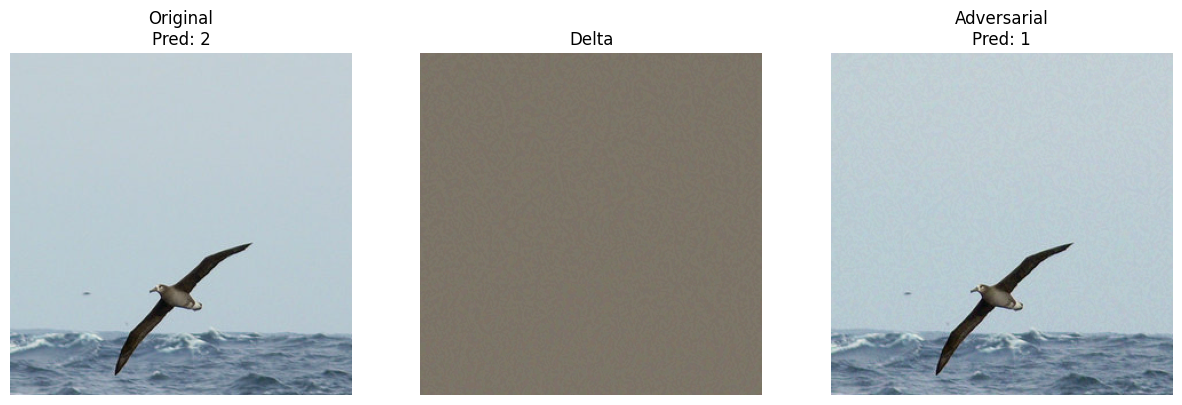

Accuracy on adversarial examples: 2.34%


In [ ]:
attack_and_visualize(sequential, test_loader, attack_config)

## Attacking with different values of eps

sequential 0.0005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 34.92%
joint_model 0.0005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 28.75%
standard_model 0.0005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 43.13%
sequential 0.001


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 21.82%
joint_model 0.001


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 13.65%
standard_model 0.001


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 23.58%
sequential 0.0025


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 15.33%
joint_model 0.0025


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 5.30%
standard_model 0.0025


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 6.89%
sequential 0.005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 13.57%
joint_model 0.005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 4.54%
standard_model 0.005


PGD - Batches:   0%|          | 0/182 [00:00<?, ?it/s]

Accuracy on adversarial examples: 2.87%


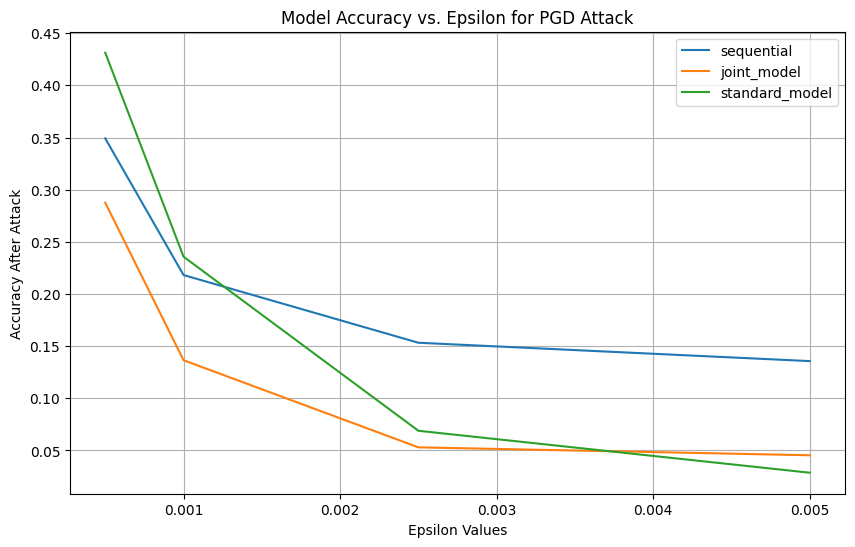

In [ ]:
import matplotlib.pyplot as plt

# Define a range of epsilon values
eps_values = [0.0005, 0.001, 0.0025, 0.005]

# Initialize a dictionary to store accuracies for each model
accuracies = {'sequential': [], 'joint_model': [], 'standard_model': []}

# Define your models here
models = {'sequential': sequential, 'joint_model': joint_model, 'standard_model': standard_model}

for eps in eps_values:
    # Update attack_config with the current eps value
    attack_config['eps'] = eps
    for model_name, model in models.items():
        # Execute the attack
        print(model_name, eps)
        accuracy = attack_pgd(model, test_loader, attack_config)
        # Store the accuracy
        accuracies[model_name].append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
for model_name, acc_list in accuracies.items():
    plt.plot(eps_values, acc_list, label=model_name)

plt.xlabel('Epsilon Values')
plt.ylabel('Accuracy After Attack')
plt.title('Model Accuracy vs. Epsilon for PGD Attack')
plt.legend()
plt.grid(True)
plt.show()